In [2]:
import pandas as pd

df = pd.read_csv("market_features_master.csv", index_col=0, parse_dates=True)
df.head()


,SP500_price,NASDAQ_price,ARKK_price,IVV_price,QQQ_price,SPY_price,VTI_price,SP500_ret,NASDAQ_ret,ARKK_ret,...,QQQ_alpha_sp500,SPY_alpha_sp500,VTI_alpha_sp500,SP500_alpha_nasdaq,NASDAQ_alpha_nasdaq,ARKK_alpha_nasdaq,IVV_alpha_nasdaq,QQQ_alpha_nasdaq,SPY_alpha_nasdaq,VTI_alpha_nasdaq
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-02,3826.310059,13612.780273,144.482330,357.853271,318.399597,357.220337,187.035309,0.013898,0.015622,0.029940,...,0.002416,0.000242,0.000446,-0.001724,0.0,0.014318,-0.001427,0.000692,-0.001482,-0.001278
2021-02-03,3830.169922,13610.540039,143.715118,358.133606,317.136353,357.501221,187.315643,0.001009,-0.000165,-0.005310,...,-0.004976,-0.000222,0.000490,0.001173,0.0,-0.005146,0.000948,-0.003803,0.000951,0.001663
2021-02-04,3871.739990,13777.740234,145.918411,362.189056,320.887054,361.564514,189.689468,0.010853,0.012285,0.015331,...,0.000973,0.000512,0.001820,-0.001431,0.0,0.003046,-0.000961,-0.000458,-0.000919,0.000388
2021-02-05,3886.830078,13856.299805,147.010208,363.609375,321.975372,362.987579,190.754883,0.003897,0.005702,0.007482,...,-0.000506,0.000038,0.001719,-0.001804,0.0,0.001780,-0.001780,-0.002310,-0.001766,-0.000085
2021-02-08,3915.590088,13987.639648,150.797089,366.347290,324.132416,365.609009,192.465134,0.007399,0.009479,0.025759,...,-0.000700,-0.000178,0.001566,-0.002079,0.0,0.016281,-0.001949,-0.002779,-0.002257,-0.000513


In [3]:
df.columns

Index(['SP500_price', 'NASDAQ_price', 'ARKK_price', 'IVV_price', 'QQQ_price',
       'SPY_price', 'VTI_price', 'SP500_ret', 'NASDAQ_ret', 'ARKK_ret',
       'IVV_ret', 'QQQ_ret', 'SPY_ret', 'VTI_ret', 'SP500_logret',
       'NASDAQ_logret', 'ARKK_logret', 'IVV_logret', 'QQQ_logret',
       'SPY_logret', 'VTI_logret', 'SP500_vol20', 'NASDAQ_vol20', 'ARKK_vol20',
       'IVV_vol20', 'QQQ_vol20', 'SPY_vol20', 'VTI_vol20', 'SP500_direction',
       'NASDAQ_direction', 'ARKK_direction', 'IVV_direction', 'QQQ_direction',
       'SPY_direction', 'VTI_direction', 'SP500_alpha_sp500',
       'NASDAQ_alpha_sp500', 'ARKK_alpha_sp500', 'IVV_alpha_sp500',
       'QQQ_alpha_sp500', 'SPY_alpha_sp500', 'VTI_alpha_sp500',
       'SP500_alpha_nasdaq', 'NASDAQ_alpha_nasdaq', 'ARKK_alpha_nasdaq',
       'IVV_alpha_nasdaq', 'QQQ_alpha_nasdaq', 'SPY_alpha_nasdaq',
       'VTI_alpha_nasdaq'],
      dtype='object')

### Benchmark GARCH Returns

In [4]:
#pip install arch 
#!pip install prophet
#!pip install tensorflow-macos #for windows, it's without the "-macos"
#!pip install tensorflow-metal


In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np

# ================================
# FIX: Disable GPU BEFORE TF loads
# ================================
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("TensorFlow running on CPU only.")

# Now safe to import Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from prophet import Prophet



TensorFlow running on CPU only.


In [5]:
# =========================================================
# LOAD DATA
# =========================================================

df = pd.read_csv("market_features_master.csv", index_col=0, parse_dates=True)

# Return series to benchmark
return_cols = [
    "SP500_ret", "NASDAQ_ret",
    "SPY_ret", "QQQ_ret", "VTI_ret", "IVV_ret", "ARKK_ret"
]

results = []


# =========================================================
# HELPER: LSTM SEQUENCE BUILDER
# =========================================================

def create_lstm_sequences(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)


# =========================================================
# BENCHMARK LOOP FOR EACH ASSET
# =========================================================

for col in return_cols:
    print(f"\n==============================")
    print(f"Benchmarking for {col}")
    print(f"==============================\n")

    y = df[col].dropna()

    # Train-test split
    split = int(len(y) * 0.8)
    y_train = y[:split]
    y_test = y[split:]

    # -----------------------------------------------------
    # 1. RANDOM WALK BASELINE
    # -----------------------------------------------------
    rw_pred = y_train.shift(1).iloc[-len(y_test):]
    rw_mse = mean_squared_error(y_test, rw_pred)
    rw_mae = mean_absolute_error(y_test, rw_pred)

   # -----------------------------------------------------
    # 2. GARCH (FIXED VERSION)
    # -----------------------------------------------------
    try:
        garch = arch_model(y_train, vol="Garch", p=1, q=1, dist="normal")
        garch_fit = garch.fit(disp="off")

        forecast = garch_fit.forecast(horizon=len(y_test))

        # FIX: extract correct forecast vector
        garch_pred = forecast.mean.iloc[-1].values

        garch_mse = mean_squared_error(y_test, garch_pred)
        garch_mae = mean_absolute_error(y_test, garch_pred)

    except Exception as e:
        print(f"❌ GARCH failed for {col}: {e}")
        garch_mse, garch_mae = np.nan, np.nan

    # -----------------------------------------------------
    # 3. PROPHET
    # -----------------------------------------------------
    try:
        prophet_df = y.reset_index()
        prophet_df.columns = ["ds", "y"]

        train_df = prophet_df.iloc[:split]
        test_df = prophet_df.iloc[split:]

        m = Prophet()
        m.fit(train_df)

        future = m.make_future_dataframe(periods=len(test_df))
        forecast = m.predict(future)

        prophet_pred = forecast["yhat"].iloc[-len(test_df):].values

        prophet_mse = mean_squared_error(test_df["y"], prophet_pred)
        prophet_mae = mean_absolute_error(test_df["y"], prophet_pred)

    except Exception as e:
        print(f"❌ Prophet failed for {col}: {e}")
        prophet_mse, prophet_mae = np.nan, np.nan

    # -----------------------------------------------------
    # 4. LSTM (CPU ONLY — FIXED)
    # -----------------------------------------------------
    try:
        scaler = MinMaxScaler()
        y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

        y_train_scaled = y_scaled[:split]
        y_test_scaled = y_scaled[split:]

        X_train, y_train_lstm = create_lstm_sequences(y_train_scaled)
        X_test, y_test_lstm = create_lstm_sequences(y_test_scaled)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        model.fit(X_train, y_train_lstm, epochs=10, batch_size=16, verbose=0)

        lstm_pred_scaled = model.predict(X_test)
        lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

        true_test = y.iloc[-len(lstm_pred):]

        lstm_mse = mean_squared_error(true_test, lstm_pred)
        lstm_mae = mean_absolute_error(true_test, lstm_pred)

    except Exception as e:
        print(f"❌ LSTM failed for {col}: {e}")
        lstm_mse, lstm_mae = np.nan, np.nan

    # -----------------------------------------------------
    # SAVE RESULTS
    # -----------------------------------------------------
    results.append({
        "Asset": col,
        "RW_MSE": rw_mse, "RW_MAE": rw_mae,
        "GARCH_MSE": garch_mse, "GARCH_MAE": garch_mae,
        "Prophet_MSE": prophet_mse, "Prophet_MAE": prophet_mae,
        "LSTM_MSE": lstm_mse, "LSTM_MAE": lstm_mae
    })


# =========================================================
# FINAL RESULTS TABLE
# =========================================================

results_df = pd.DataFrame(results)
print("\n===== FINAL BENCHMARK RESULTS =====\n")
print(results_df)

results_df.to_csv("benchmark_results.csv", index=False)
print("\nSaved results to benchmark_results.csv")


/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
22:05:40 - cmdstanpy - INFO - Chain [1] start processing
22:05:40 - cmdstanpy - INFO - Chain [1] done processing



Benchmarking for SP500_ret



/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
22:05:43 - cmdstanpy - INFO - Chain [1] start processing
22:05:43 - cmdstanpy - INFO - Chain [1] done processing



Benchmarking for NASDAQ_ret



/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001411. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
22:05:46 - cmdstanpy - INFO - Chain [1] start processing
22:05:46 - cmdstanpy - INFO - Chain [1] done processing



Benchmarking for SPY_ret



/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002555. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
22:05:50 - cmdstanpy - INFO - Chain [1] start processing
22:05:50 - cmdstanpy - INFO - Chain [1] done processing



Benchmarking for QQQ_ret



/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001502. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
22:05:53 - cmdstanpy - INFO - Chain [1] start processing
22:05:53 - cmdstanpy - INFO - Chain [1] done processing



Benchmarking for VTI_ret



/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
22:05:56 - cmdstanpy - INFO - Chain [1] start processing
22:05:56 - cmdstanpy - INFO - Chain [1] done processing



Benchmarking for IVV_ret



/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
22:06:00 - cmdstanpy - INFO - Chain [1] start processing
22:06:00 - cmdstanpy - INFO - Chain [1] done processing



Benchmarking for ARKK_ret



/Users/jovitagandhi/opt/anaconda3/envs/tfarm/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

===== FINAL BENCHMARK RESULTS =====

        Asset    RW_MSE    RW_MAE  GARCH_MSE  GARCH_MAE  Prophet_MSE  \
0   SP500_ret  0.000180  0.010541   0.000053   0.005715     0.000073   
1  NASDAQ_ret  0.000333  0.014585   0.000095   0.007643     0.000127   
2     SPY_ret  0.000179  0.010493   0.000052   0.005667     0.000073   
3     QQQ_ret  0.000344  0.014814   0.000100   0.007814     0.000138   
4     VTI_ret  0.000191  0.010862   0.000057   0.005968     0.000077   
5     IVV_ret  0.000179  0.010485   0.000052   0.005699     0.000074   
6    ARKK_ret  0.001693  0.033792   0.000551   0.018184     0.000626   

   Prophet_MAE  LSTM_MSE  LSTM_MAE  
0     0.006676  0.000056  0.005856  
1     0.008836  0.000098  0.007913  
2     0.006637  0.000056  0.005889  
3     0.009164  0.000123  0.009093  
4     0.006862  0.000057  0.005981  
5     0.006672  0.000053  0.005788  
6     0.019478  0.000611  0.018947  

Saved results to benchmark_results.csv


In [6]:
import pandas as pd

# Load benchmark results
results = pd.read_csv("benchmark_results.csv")

# Display in a clean formatted table
pd.set_option("display.precision", 6)
results


,Asset,RW_MSE,RW_MAE,GARCH_MSE,GARCH_MAE,Prophet_MSE,Prophet_MAE,LSTM_MSE,LSTM_MAE
0,SP500_ret,0.000180,0.010541,0.000053,0.005715,0.000073,0.006676,0.000056,0.005856
1,NASDAQ_ret,0.000333,0.014585,0.000095,0.007643,0.000127,0.008836,0.000098,0.007913
2,SPY_ret,0.000179,0.010493,0.000052,0.005667,0.000073,0.006637,0.000056,0.005889
3,QQQ_ret,0.000344,0.014814,0.000100,0.007814,0.000138,0.009164,0.000123,0.009093
4,VTI_ret,0.000191,0.010862,0.000057,0.005968,0.000077,0.006862,0.000057,0.005981
5,IVV_ret,0.000179,0.010485,0.000052,0.005699,0.000074,0.006672,0.000053,0.005788
6,ARKK_ret,0.001693,0.033792,0.000551,0.018184,0.000626,0.019478,0.000611,0.018947


<Figure size 1200x600 with 0 Axes>

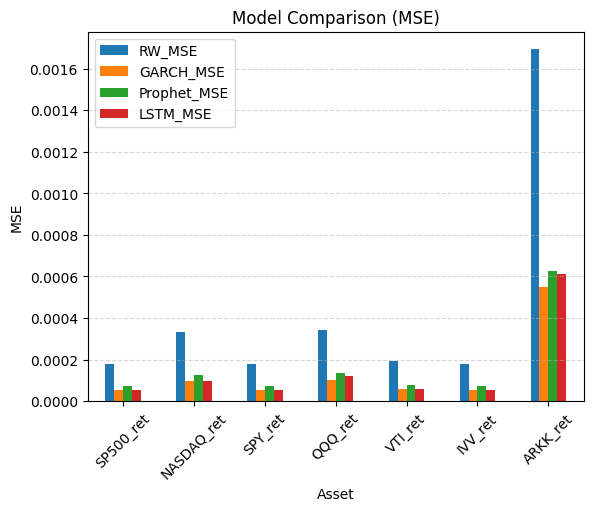

In [7]:
import matplotlib.pyplot as plt

metrics = ["RW_MSE", "GARCH_MSE", "Prophet_MSE", "LSTM_MSE"]

results_plot = results.set_index("Asset")[metrics]

plt.figure(figsize=(12,6))
results_plot.plot(kind="bar")
plt.title("Model Comparison (MSE)")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


<Figure size 1200x600 with 0 Axes>

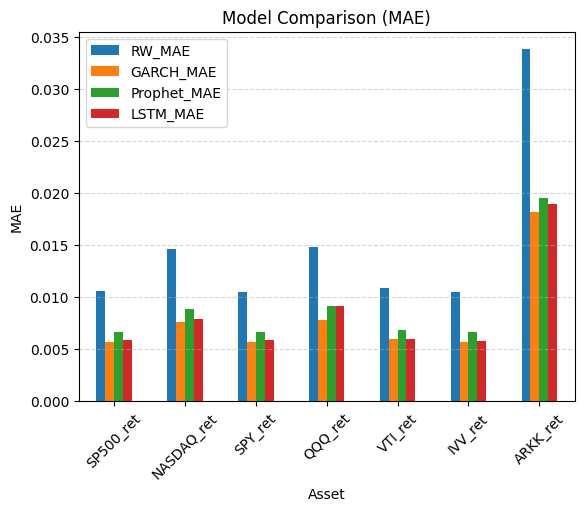

In [8]:
metrics = ["RW_MAE", "GARCH_MAE", "Prophet_MAE", "LSTM_MAE"]

results_plot = results.set_index("Asset")[metrics]

plt.figure(figsize=(12,6))
results_plot.plot(kind="bar")
plt.title("Model Comparison (MAE)")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()
